# Training U-Net model for coastline semantic segmentation using PyTorch

In [2]:
#Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random
import glob

import cv2 as cv
from PIL import Image
from osgeo import gdal

import torch 
import torch.nn as nn

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

fig_path = '/Users/conorosullivan/Google Drive/My Drive/UCD/research/Interpreting UNet/Figures/{}.png'

In [3]:
def get_rgb(img):
    """Return normalized RGB channels from sentinal image"""
    img = np.array(img)
    
    print(img.shape)
    rgb_img = np.stack([img[3],img[2],img[1]],axis=-1)
    print(rgb_img.shape)
    rgb_normalize = np.clip(rgb_img, 0, 0.3)/0.3
    
    return rgb_normalize

## Dataset

In [4]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, paths, transforms):

        self.paths = paths
        self.transforms = transforms

    def __getitem__(self, idx):
        """Get image and binary mask for a given index"""

        path = self.paths[idx]

        if 'train' in path: 
            image, mask = self.load_train(path)
        elif 'test' in path: 
            image, mask = self.load_test(path)
        
        target = torch.Tensor(mask)

        return image, target

    def load_train(self,path):

        """Return image and mask for training images"""
        # Get image
        image = np.load(path)
        image = self.scale_img(image)

        # Get target
        mask_path = path.replace("images","labels").replace("image","chip")
        mask = np.load(mask_path)

        return image, mask

    def load_test(self, path):
       
        """Return image and mask for test set"""
    
        # Get image 
        image = gdal.Open(path).ReadAsArray()
        image = np.stack(image, axis=-1)
        image = self.scale_img(image)

        # Get mask
        mask_path = path.replace("images","labels").replace("image","label")
        mask= gdal.Open(mask_path).ReadAsArray()
        mask = np.array(mask).astype(np.int8)
        
        return image, mask
    
    def scale_img(self,image):
        """Scale all image bands to 0-1"""

        image = np.array(image)
        image = image.astype(np.float32)
        """for i in range(image.shape[0]):
            image[i] = cv.normalize(image[i], None, 0, 1, norm_type=cv.NORM_MINMAX)"""

        # Convert to tensor
        image = image.transpose(2,0,1)
        image = torch.tensor(image)

        return image

    def __len__(self):
        return len(self.paths)

In [5]:
paths = glob.glob("../../data/SWED/train/images/*")
paths = random.choices(paths, k=1000)
paths = [path for path in paths if check_img(path)]
print(paths[0])
# Shuffle the paths
random.shuffle(paths)
paths[0]

NameError: name 'check_img' is not defined

In [6]:
TRANSFORMS = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

paths = glob.glob("../../data/SWED/train/images/*")
paths = random.choices(paths, k=1000)

# Remove paths with no data
def check_img(path):
    img = np.load(path)
    # Check if the image is NOT all zeros
    test = (np.max(img) + np.min(img) != 0)
    return test

paths = [path for path in paths if check_img(path)]

# Shuffle the paths
random.shuffle(paths)

# Create a datasets for training and validation
split = int(0.9 * len(paths))
train_data = TrainDataset(paths[:split], TRANSFORMS)
valid_data = TrainDataset(paths[split:], TRANSFORMS)

# Prepare data for Pytorch model
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32)

print(train_data.__len__())
print(valid_data.__len__())

823
92


## Model Architecture

In [7]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(12, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        """ Bottleneck """
        self.b = conv_block(512, 1024)
        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b = self.b(p4)
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        """ Classifier """
        outputs = self.outputs(d4)
        outputs = torch.sigmoid(outputs)

        return outputs

In [8]:
# create a complete CNN
model = build_unet()
#print(model)

# move tensors to GPU if available
device = torch.device('mps')
model.to(device)

# specify loss function (binary cross-entropy)
criterion = nn.BCELoss()

# specify optimizer
optimizer = torch.optim.Adam(model.parameters())

In [9]:
images, target = next(iter(train_loader))
images = images.to(device)
target = target.to(device)

print(images.shape)
print(target.shape)

output = model(images)
print(output.shape)

torch.Size([32, 12, 256, 256])
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])


## Training model

In [51]:
name = "SWED_UNET_07FEB23" # Change this to save a new model

model = torch.load('../../models/SWED_UNET_19JAN23.pth')

# Train the model
min_loss = np.inf
for epoch in range(20):
    print("Epoch {} |".format(epoch+1),end=" ")
    print("{} Batchs |".format(len(train_loader)),end=" ")
    count = 1
    model = model.train()

    for images, target in iter(train_loader):
        print(count,end=" ")
        count += 1

        images = images.to(device)
        target = target.to(device)
        
        # Zero gradients of parameters
        optimizer.zero_grad()  

        # Execute model to get outputs
        output = model(images)

        # Calculate loss
        loss = criterion(output, target)

        # Run backpropogation to accumulate gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

    # Calculate validation loss
    model = model.eval()

    valid_loss = 0
    for images, target in iter(valid_loader):
        images = images.to(device)
        target = target.to(device)

        output = model(images)

        loss = criterion(output, target)
        
        valid_loss += loss.item()
   
    valid_loss /= len(valid_loader)
    print("| Validation Loss: {}".format(round(valid_loss,5)))
    
    if valid_loss < min_loss:
        print("Saving model")
        torch.save(model, '../../models/{}.pth'.format(name))

        min_loss = valid_loss
    

Epoch 1 | 26 Batchs | 1 

KeyboardInterrupt: 

## Model evaluation

In [12]:
# Load saved model 
model = torch.load('../../models/SWED_UNET_19JAN24.pth')
model.eval()
model.to(device)

# Get images and targets
images, target = next(iter(valid_loader))

# Get predictions
images = images.to(device)
output=model(images)

TypeError: cannot unpack non-iterable NoneType object

(12, 256, 256)
(256, 256, 3)


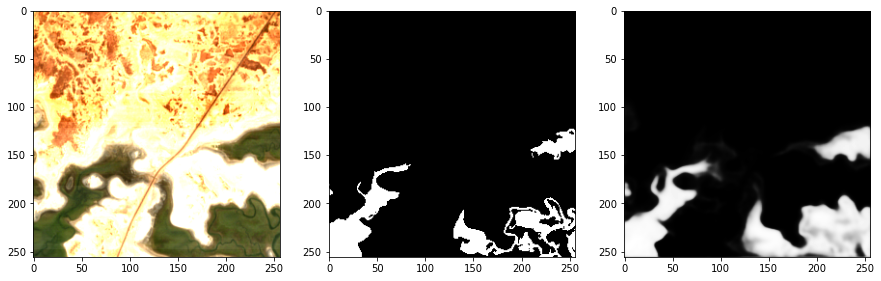

In [57]:
# Display images and predictions
rint = np.random.randint(0, len(output))

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(get_rgb(images[rint].cpu()), cmap='gray')
ax[1].imshow(target[rint][0], cmap='gray')
ax[2].imshow(torch.sigmoid(output[rint][0]).cpu().detach(), cmap='gray')


In [13]:
def get_pred(output):
    pred = output.cpu().detach().numpy()[0]

    for i in  range(pred.shape[0]):
        for j in range(pred.shape[1]):
            
            if pred[i][j] >= 0.5:
                pred[i][j] = 1
            else: 
                pred[i][j] = 0

    return pred

def calc_accuracy(pred,mask):
    x,y = pred.shape
    acc = np.sum(pred == mask.cpu().detach().numpy())/(x*y)

    return acc

In [14]:
test_paths = glob.glob("../../data/SWED/test/images/*")
test_data = TrainDataset(test_paths, TRANSFORMS)
test_loader = DataLoader(test_data, batch_size=test_data.__len__(), shuffle=True)
print(test_loader.__len__())

# Load saved model 
model = torch.load('../../models/SWED_UNET_19JAN24.pth')
model.eval()
model.to(device)

# Get images and targets
images, targets = next(iter(test_loader))

# Get predictions
images = images.to(device)
output=model(images)
predictions = [get_pred(x) for x in output]


1


Accuracy: 0.7927
(12, 256, 256)
(256, 256, 3)


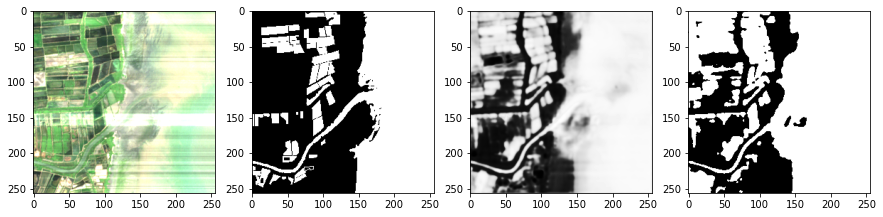

In [24]:
# Display images and predictions
rint = np.random.randint(0, len(output))

pred = predictions[rint]
mask = targets[rint]
acc = calc_accuracy(pred,mask) 
print("Accuracy: {}".format(round(acc,4)))

fig, ax = plt.subplots(1, 4, figsize=(15, 15))
ax[0].imshow(get_rgb(images[rint].cpu()), cmap='gray')
ax[1].imshow(mask, cmap='gray')
ax[2].imshow(torch.sigmoid(output[rint][0]).cpu().detach(), cmap='gray')
ax[3].imshow(pred, cmap='gray')

0.9327750692562181


<AxesSubplot:>

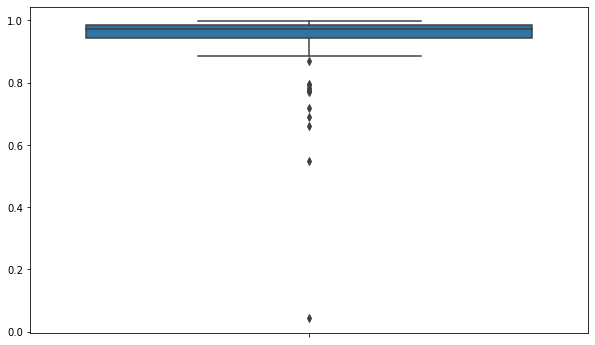

In [152]:
accuracy = [calc_accuracy(pred,mask) for pred, mask in zip(predictions,targets)]
print(np.mean(accuracy))

plt.figure(figsize=(10,6))
sns.boxplot(y=accuracy)

# Interpreting model output

### Permutation feature importance 

In [171]:
def shuffle_band(band):
    perm_image = band.ravel()
    random.shuffle(perm_image)
    perm_image.resize(256,256)

    #perm_image = torch.tensor(perm_image)

    return perm_image

In [199]:
rows = []
for i in range(len(images)):

    image = images[i]
    target = targets[i]

    original = image.cpu().detach().numpy()
    perms =[original]
    for j in range(image.shape[0]):
        perm_band = original.copy()
        perm_band[j] = shuffle_band(perm_band[j])
        perms.append(perm_band)

    perms = np.array(perms)
    perms = torch.from_numpy(perms)
    perms = perms.to(device)

    output = model(perms)
    predictions = [get_pred(x) for x in output]

    accuracy = [calc_accuracy(pred,target) for pred in predictions]

    rows.append(accuracy)
    print(i+1,end=" ")

channels = ["No Perms",'Coastal Aerosol','Blue','Green',
                 'Red','Red Edge 1','Red Edge 2',
                'Red Edge 3','NIR','Red Edge 4',
                 'Water Vapour','SWIR 1','SWIR 2']

df_accuracy = pd.DataFrame(rows,columns = channels)
df_accuracy.to_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/UNET_INTERPRET/Metrics_21JAN23.csv")
df_accuracy.head()

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 

,No Perms,Coastal Aerosol,Blue,Green,Red,Red Edge 1,Red Edge 2,Red Edge 3,NIR,Red Edge 4,Water Vapour,SWIR 1,SWIR 2
0,0.960815,0.989594,0.735855,0.921524,0.840515,0.967743,0.943130,0.805161,0.866150,0.991913,0.988983,0.984100,0.991409
1,0.948563,0.932632,0.935150,0.966843,0.900299,0.963196,0.902451,0.930771,0.735001,0.941391,0.926727,0.888916,0.955795
2,0.987091,0.986511,0.987289,0.987625,0.983032,0.988449,0.988037,0.988174,0.979660,0.987259,0.987808,0.741653,0.987961
3,0.774643,0.754242,0.742859,0.726990,0.739258,0.747559,0.778763,0.785782,0.768356,0.783371,0.588272,0.777115,0.786743
4,0.964828,0.986282,0.984024,0.717285,0.985886,0.940140,0.976974,0.978455,0.710526,0.984650,0.878586,0.790787,0.969437


In [234]:
df_accuracy = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/Interpreting UNet/Metrics_21JAN23.csv",index_col=0)

In [237]:
avg_acc = df_accuracy.mean()
original_acc = avg_acc[0]
change_acc = (original_acc - avg_acc[1:])/original_acc

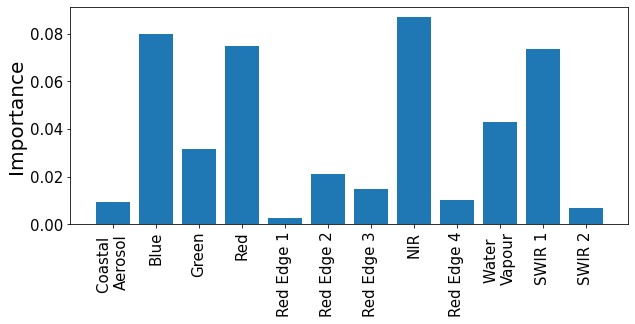

In [253]:
fig, ax  = plt.subplots(figsize=(10,4))
fig.set_facecolor('white')

plt.bar(height=change_acc,x=np.arange(0,12),)

plt.ylabel("Importance",size=20)

channels_ = ['Coastal \nAerosol','Blue','Green',
            'Red','Red Edge 1','Red Edge 2',
        'Red Edge 3','NIR','Red Edge 4',
            'Water \nVapour','SWIR 1','SWIR 2']

ax.set_xticks(np.arange(0,12),channels_,rotation=90, size=15)
plt.yticks(size=15)

plt.savefig(fig_path.format("importance"),bbox_inches='tight')

In [ ]:
import torch

# Assume that `model` is an instance of the UNet model, and `x` is a batch of input images
# with shape (batch_size, 12, H, W) where H and W are the height and width of the images

# Make sure the model is in eval mode
model.eval()

# Compute the model's output for the input images
output = model(images)

In [30]:
# Set up a gradient tensor with the same shape as the input
grad = torch.zeros_like(images).to(device)

# Compute the gradients of the output with respect to the input
output.backward(gradient=grad)

# Compute the feature importance scores as the average absolute gradient for each band
importance_scores = grad.abs().mean(dim=(0, 2, 3))

print(importance_scores)

RuntimeError: Mismatch in shape: grad_output[0] has a shape of torch.Size([32, 12, 256, 256]) and output[0] has a shape of torch.Size([32, 1, 256, 256]).

# Archive 

In [ ]:
def load_train(path):
    """Returns sentinal image, rgb image and label"""
    
    label_path = path.replace("images","labels").replace("image","chip")
   
    img = np.load(path)
    rgb_img = get_rgb(img)
    label = np.load(label_path)[0]
    
    return img, rgb_img, label


def load_test(path):
    """Returns sentinal image, rgb image and label"""
    
    img = gdal.Open(path).ReadAsArray()
    stack_img = np.stack(img, axis=-1)
    rgb_img = get_rgb(stack_img)
    
    label_path = path.replace("images","labels").replace("image","label")
    label = gdal.Open(label_path).ReadAsArray()
    
    return stack_img, rgb_img, label

In [ ]:

def conv_block(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,)
    return model


def conv_trans_block(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim, out_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,)
    return model


def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool


def conv_block_2(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        conv_block(in_dim, out_dim, act_fn),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model

def conv_block_3(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        conv_block(in_dim, out_dim, act_fn),
        conv_block(out_dim, out_dim, act_fn),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model

class unet(nn.Module):
    def __init__(self, in_dim, out_dim, num_filter):
        super(unet, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        act_fn = nn.LeakyReLU(0.2, inplace=True)

        self.down_1 = conv_block_2(self.in_dim, self.num_filter, act_fn)
        self.pool_1 = maxpool()
        self.down_2 = conv_block_2(self.num_filter * 1, self.num_filter * 2, act_fn)
        self.pool_2 = maxpool()
        self.down_3 = conv_block_2(self.num_filter * 2, self.num_filter * 4, act_fn)
        self.pool_3 = maxpool()
        self.down_4 = conv_block_2(self.num_filter * 4, self.num_filter * 8, act_fn)
        self.pool_4 = maxpool()

        self.bridge = conv_block_2(self.num_filter * 8, self.num_filter * 16, act_fn)

        self.trans_1 = conv_trans_block(self.num_filter * 16, self.num_filter * 8, act_fn)
        self.up_1 = conv_block_2(self.num_filter * 16, self.num_filter * 8, act_fn)
        self.trans_2 = conv_trans_block(self.num_filter * 8, self.num_filter * 4, act_fn)
        self.up_2 = conv_block_2(self.num_filter * 8, self.num_filter * 4, act_fn)
        self.trans_3 = conv_trans_block(self.num_filter * 4, self.num_filter * 2, act_fn)
        self.up_3 = conv_block_2(self.num_filter * 4, self.num_filter * 2, act_fn)
        self.trans_4 = conv_trans_block(self.num_filter * 2, self.num_filter * 1, act_fn)
        self.up_4 = conv_block_2(self.num_filter * 2, self.num_filter * 1, act_fn)

        self.out = nn.Sequential(nn.Conv2d(self.num_filter, self.out_dim, 3, 1, 1), nn.Tanh())

    def forward(self, input):
        down_1 = self.down_1(input)
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4)

        bridge = self.bridge(pool_4)

        trans_1 = self.trans_1(bridge)
        concat_1 = torch.cat([trans_1, down_4], dim=1)
        up_1 = self.up_1(concat_1)
        trans_2 = self.trans_2(up_1)
        concat_2 = torch.cat([trans_2, down_3], dim=1)
        up_2 = self.up_2(concat_2)
        trans_3 = self.trans_3(up_2)
        concat_3 = torch.cat([trans_3, down_2], dim=1)
        up_3 = self.up_3(concat_3)
        trans_4 = self.trans_4(up_3)
        concat_4 = torch.cat([trans_4, down_1], dim=1)
        up_4 = self.up_4(concat_4)

        out = self.out(up_4)

        return out